In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/consume-complaints-dataset-fo-nlp/complaints_processed.csv


In [2]:
!git clone https://github.com/victoriamuinde07/NPL-Customer-Complaint-Project.git

Cloning into 'NPL-Customer-Complaint-Project'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 30 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 88.90 KiB | 4.44 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [3]:
import nltk
nltk_data_dir = "/kaggle/working/nltk_data"
nltk.data.path.append(nltk_data_dir)

In [4]:
import nltk
import os

# Create the directory if it doesn't exist
os.makedirs(nltk_data_dir, exist_ok=True)

# Download required resources
nltk.download("stopwords", download_dir=nltk_data_dir)
nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download("wordnet", download_dir=nltk_data_dir)
nltk.download("omw-1.4", download_dir=nltk_data_dir)


[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /kaggle/working/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...


True

In [5]:
wordnet_path = os.path.join(nltk_data_dir, "corpora", "wordnet")
stopwords_path = os.path.join(nltk_data_dir, "corpora", "stopwords")

print("WordNet directory exists:", os.path.exists(wordnet_path))
print("Stopwords directory exists:", os.path.exists(stopwords_path))


WordNet directory exists: False
Stopwords directory exists: True


In [6]:
import nltk
nltk.download("wordnet", download_dir=nltk_data_dir)
nltk.download("omw-1.4", download_dir=nltk_data_dir)  # Ensure WordNet dependencies are also downloaded


[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
import os

wordnet_path = os.path.join(nltk_data_dir, "corpora", "wordnet")
print("WordNet directory exists:", os.path.exists(wordnet_path))


WordNet directory exists: False


In [8]:
import os

for root, dirs, files in os.walk(nltk_data_dir):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)


Root: /kaggle/working/nltk_data
Directories: ['corpora', 'tokenizers']
Files: []
----------------------------------------
Root: /kaggle/working/nltk_data/corpora
Directories: ['stopwords']
Files: ['stopwords.zip', 'omw-1.4.zip', 'wordnet.zip']
----------------------------------------
Root: /kaggle/working/nltk_data/corpora/stopwords
Directories: []
Files: ['kazakh', 'swedish', 'russian', 'catalan', 'french', 'dutch', 'finnish', 'tajik', 'danish', 'nepali', 'romanian', 'turkish', 'indonesian', 'chinese', 'arabic', 'norwegian', 'slovene', 'hinglish', 'README', 'bengali', 'greek', 'basque', 'german', 'hebrew', 'hungarian', 'italian', 'spanish', 'english', 'azerbaijani', 'portuguese']
----------------------------------------
Root: /kaggle/working/nltk_data/tokenizers
Directories: ['punkt']
Files: ['punkt.zip']
----------------------------------------
Root: /kaggle/working/nltk_data/tokenizers/punkt
Directories: ['PY3']
Files: ['portuguese.pickle', 'malayalam.pickle', 'finnish.pickle', 'tur

In [9]:
import zipfile
import os

corpora_dir = "/kaggle/working/nltk_data/corpora"
wordnet_zip = os.path.join(corpora_dir, "wordnet.zip")
omw_zip = os.path.join(corpora_dir, "omw-1.4.zip")

# Extract WordNet
with zipfile.ZipFile(wordnet_zip, 'r') as zip_ref:
    zip_ref.extractall(corpora_dir)

# Extract omw-1.4
with zipfile.ZipFile(omw_zip, 'r') as zip_ref:
    zip_ref.extractall(corpora_dir)

print("Extraction complete.")


Extraction complete.


In [10]:
for root, dirs, files in os.walk(corpora_dir):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)


Root: /kaggle/working/nltk_data/corpora
Directories: ['wordnet', 'stopwords', 'omw-1.4']
Files: ['stopwords.zip', 'omw-1.4.zip', 'wordnet.zip']
----------------------------------------
Root: /kaggle/working/nltk_data/corpora/wordnet
Directories: []
Files: ['adv.exc', 'data.adj', 'LICENSE', 'lexnames', 'data.noun', 'data.verb', 'index.adj', 'index.verb', 'cntlist.rev', 'adj.exc', 'README', 'citation.bib', 'noun.exc', 'data.adv', 'verb.exc', 'index.adv', 'index.noun', 'index.sense']
----------------------------------------
Root: /kaggle/working/nltk_data/corpora/stopwords
Directories: []
Files: ['kazakh', 'swedish', 'russian', 'catalan', 'french', 'dutch', 'finnish', 'tajik', 'danish', 'nepali', 'romanian', 'turkish', 'indonesian', 'chinese', 'arabic', 'norwegian', 'slovene', 'hinglish', 'README', 'bengali', 'greek', 'basque', 'german', 'hebrew', 'hungarian', 'italian', 'spanish', 'english', 'azerbaijani', 'portuguese']
----------------------------------------
Root: /kaggle/working/nltk_

In [11]:
from nltk.corpus import wordnet

print(wordnet.synsets("computer"))  # Example word to test


[Synset('computer.n.01'), Synset('calculator.n.01')]


In [12]:
os.remove(wordnet_zip)
os.remove(omw_zip)
print("ZIP files removed.")


ZIP files removed.


### Bank Customer Complaints Classification

### Executive Summary.
This project leverages Natural Language Processing(NLP) to streamline customer complaint classification,aiming to reduce the time and complexity customers face when submitting complaints.By implementing an NLP model that automatically categorizes complaints based on content,the system eliminates the need for customers to navigate through numerous questions or options.The project's primary goals are to minimize the time spent on logging complaints and to enhance user experience with a simple,intuitive interface.

To achieve these goals,the project trained and evaluated various machine learning models,including Multinomial Naive Bayes,Support Vector Machine(SVM),Logistic Regression,Random Forest,and an ensembe model(ExtraTrees),before training and selecting a transformer-based model,BERT.The BERT model excelled in handling language tasks,achieving a Macro F1-score of 0.85,weighted F1-score of 0.89,and an accuracy of 89%,showing strong performance across all complaint categories.The focus on Macro F1-score ensured balanced classification

### Data Exploration

In [13]:
#importing necessary libraries.
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier

from imblearn.over_sampling import SMOTE
import joblib





In [14]:
df = pd.read_csv('/kaggle/input/consume-complaints-dataset-fo-nlp/complaints_processed.csv')
df.head(20)

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...
5,5,credit_reporting,payment history missing credit report made mis...
6,6,credit_reporting,va date complaint experian credit bureau invol...
7,7,credit_reporting,account reported abbreviated name full name se...
8,8,credit_reporting,account reported abbreviated name full name se...
9,9,credit_reporting,usdoexxxx account reported abbreviated name fu...


In [15]:
# Displaying basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


The dataset has 162421 entries and three columns.
Unnamed:0 Appears to be an index column and can be ignored or removed.
Product-Contains the complaint category(target variable) with values like credit_card,retail_banking,credit_reporting etc.
#### There are 10 missing entries in the narrative column

In [16]:
# dropping the unnecessary 'Unnamed: 0' column.
df = df.drop(columns=['Unnamed: 0'])
# dropping rows with missing values in the narrative column
df = df.dropna(subset=['narrative'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162411 entries, 0 to 162420
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    162411 non-null  object
 1   narrative  162411 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


In [17]:
#checking for duplicate rows on 'product','narrative'
duplicates = df.duplicated(subset=['product','narrative']).sum()
duplicates

37735

There are 37,735 duplicate entries in the dataset based on product and narrative columns.However,I'll keep them since during model selection and training,I noted that removing the duplicates would negatively impact our best model performance.

In [18]:
# checking the distribution of the 'product' categories
product_dist = df['product'].value_counts()
product_dist

product
credit_reporting       91172
debt_collection        23148
mortgages_and_loans    18990
credit_card            15566
retail_banking         13535
Name: count, dtype: int64

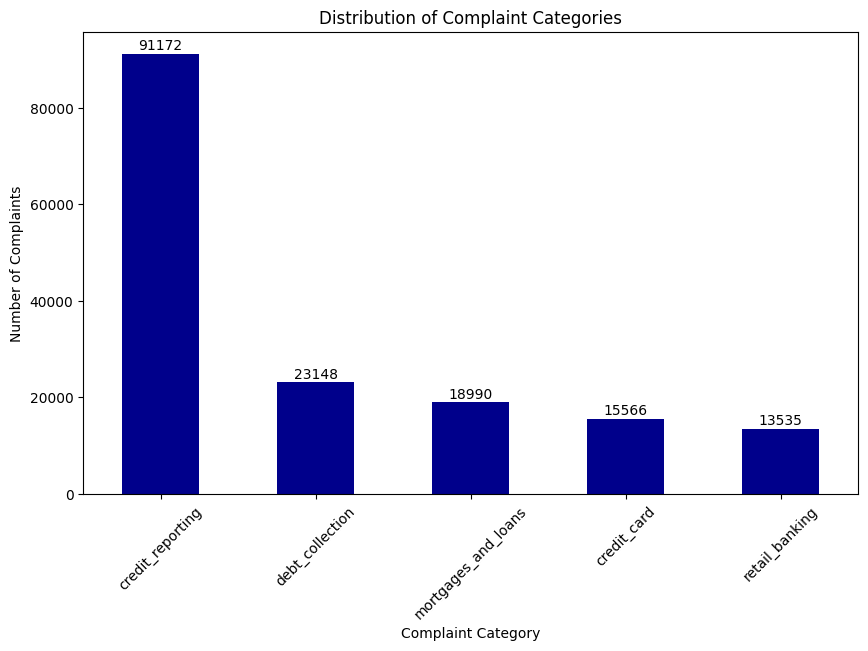

In [19]:
# plotting the distribution of complaint categories.
plt.figure(figsize=(10,6))
ax = product_dist.plot(kind='bar',color='darkblue')
plt.title('Distribution of Complaint Categories')
plt.xlabel('Complaint Category')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)

#adding count on top of each bar.
for i,count in enumerate(product_dist):
    ax.text(i,count + 200,str(count),ha='center',va='bottom')
plt.show()

The distribution shows a class imbalance,with credit_reporting category significantly more represented than others.
I accounted for the imbalance through stratify parameter when separating the features and target to ensure that the class distribution in the training and testing sets matches that of the original dataset.
Synthetic Minority Oversampling Technique(SMOTE) was also applied later to check if it improved model performance

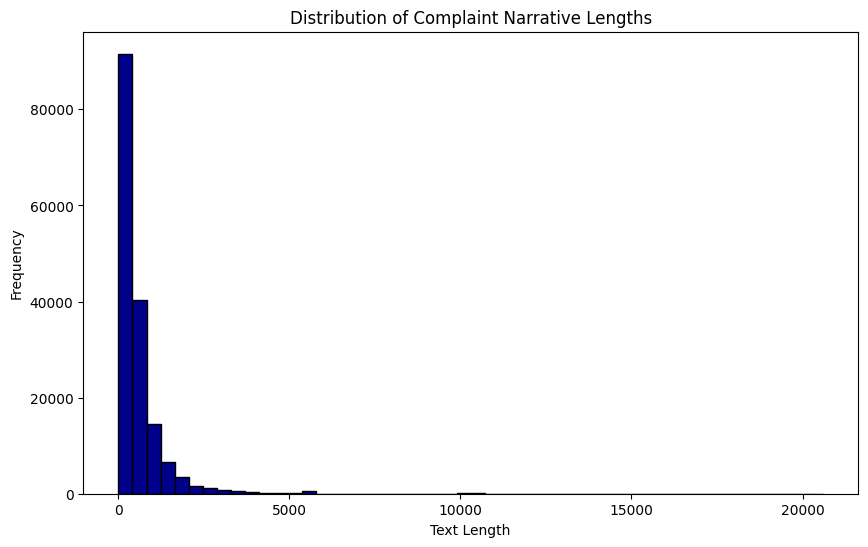

count    162411.000000
mean        588.535838
std         830.977413
min           3.000000
25%         192.000000
50%         361.000000
75%         683.000000
max       20596.000000
Name: text_length, dtype: float64

In [20]:
# Calculating the length of each complainy narrative
df['text_length'] = df['narrative'].apply(len)
text_length_summary = df['text_length'].describe()

#plotting the distribution of the text length.
plt.figure(figsize=(10,6))
plt.hist(df['text_length'],bins=50,color='darkblue',edgecolor='black')
plt.title('Distribution of Complaint Narrative Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

text_length_summary

The histogram indicates a right-skewed distribution,with most narratives having fewer than 1000 characters.This information helps in choosing an appropriate text processing approach and handling extremely short or long complaints if necessary.

#### Data Preprocessing

In [21]:
import nltk

try:
    wordnet_path = nltk.data.find("corpora/wordnet")
    print("WordNet is located at:", wordnet_path)
except LookupError:
    print("WordNet corpus not found.")


WordNet is located at: /kaggle/working/nltk_data/corpora/wordnet


In [22]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join words back into a single string with whitespace handling
    cleaned_text = ' '.join(words).strip()  # Remove leading/trailing whitespace
    return ' '.join(cleaned_text.split())    # Replace multiple spaces with a single space

# Apply preprocessing to the 'narrative' column
df['cleaned_narrative'] = df['narrative'].apply(preprocess_text)
df[['narrative','cleaned_narrative']].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,narrative,cleaned_narrative
0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...
1,forwarded message date tue subject please inve...,forwarded message date tue subject please inve...
2,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...
3,payment history missing credit report speciali...,payment history missing credit report speciali...
4,payment history missing credit report made mis...,payment history missing credit report made mis...


Key steps included:
#### Lowercasing
Ensures uniformity.
#### Removing Special Characters and Numbers.
Cleans up non-essential elements.
#### Tokenization.
Splits text into words.
#### Stop Word Removal.
Filters out common but non-informative words.
#### Lemmatization.
Reduces words to their root forms.
#### Whitespace Handling.
Trims leading/trailing whitespace and replaces multiples spaces with a single space for consistency.

The pipeline gives a well-processed cleaned_narrative column,ready for further transformation into numerical features using appropriate techniques.

In [23]:
#counting words in each complaint
df['word_count'] = df['cleaned_narrative'].apply(lambda x: len(x.split()))

#getting summary statistics for word counts
word_count_summary = df['word_count'].describe()
print('Word Count Summary:\n',word_count_summary)

Word Count Summary:
 count    162411.000000
mean         80.207935
std         108.821314
min           1.000000
25%          27.000000
50%          50.000000
75%          95.000000
max        2684.000000
Name: word_count, dtype: float64


The word count summary shows that the complaints vary widely in length,with an average of 80 words and a median of 50 words.The standard deviation of 108 suggests significant variability,and the range spans from 1 to 2,684 words,indicating some complaints are very brief while others are extremely detailed.This distribution is right-skewed,with a small number of long complaints inflating the mean.While experimenting on preprocessing and modelling,I noted that filtering the words didn't further didn't improve the models so i kept them as they are

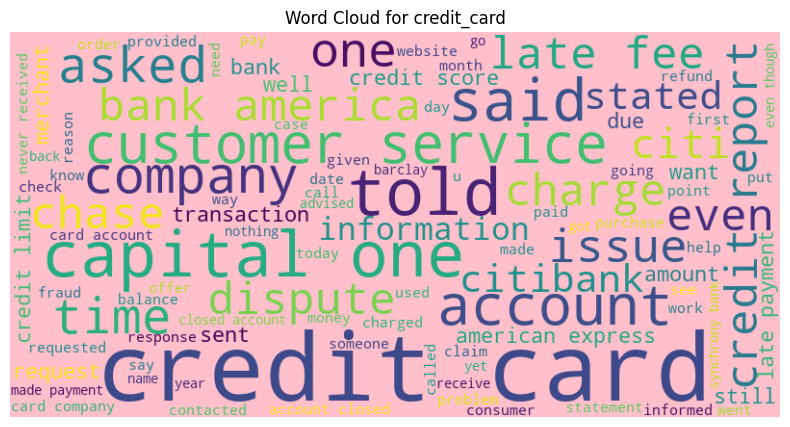

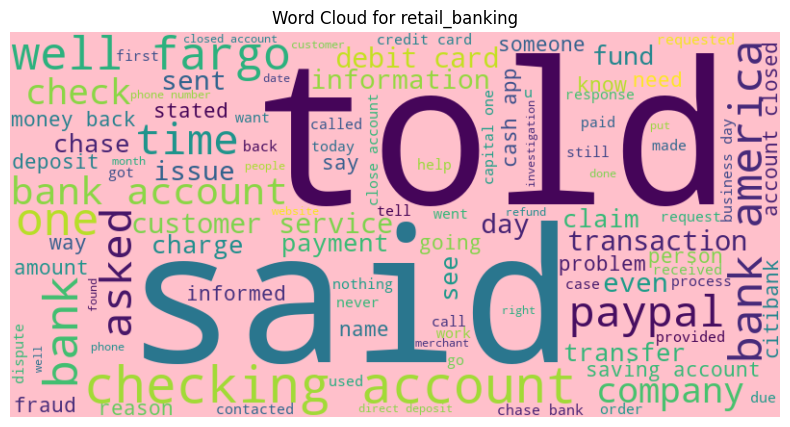

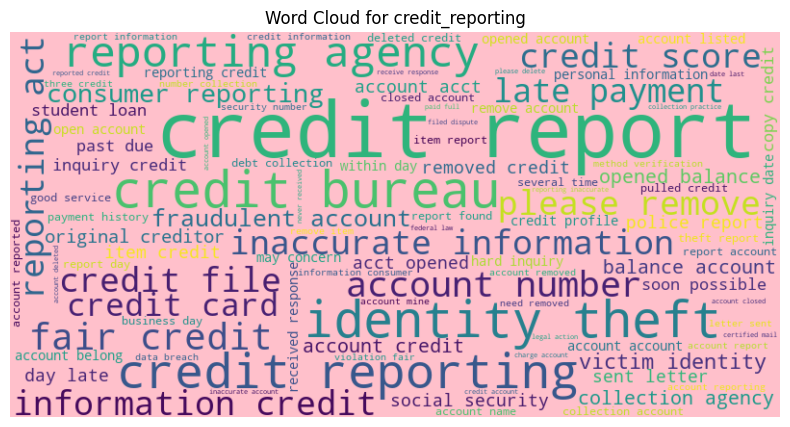

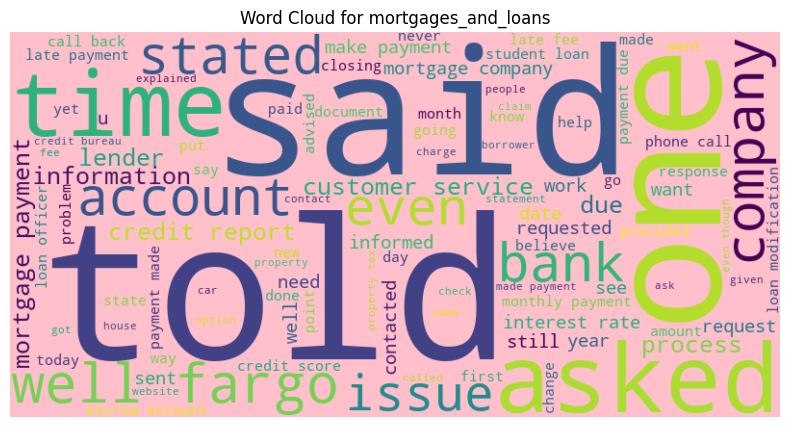

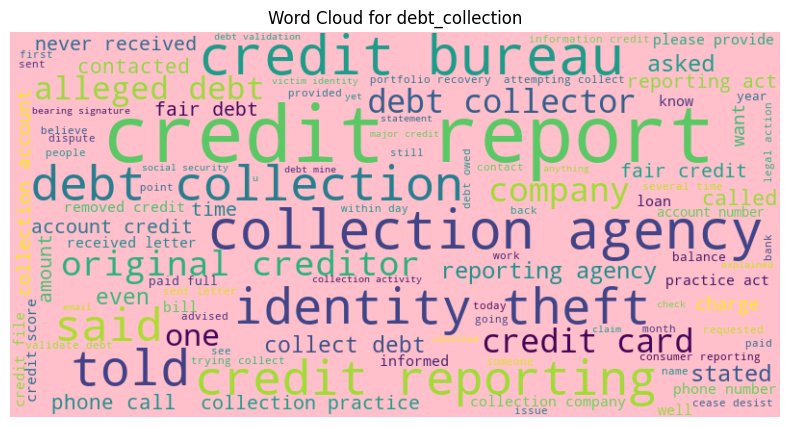

In [24]:
#function to generate word cloud for each product label
def generate_word_cloud(data,product_label):
    text = ' '.join(data['cleaned_narrative'][data['product'] == product_label])
    wordcloud = WordCloud(width=800, height=400,background_color = 'pink',max_words=100).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.title(f'Word Cloud for {product_label}')
    plt.axis('off')
    plt.show()

#getting unique product labels
product_labels = df['product'].unique()

#generating and displaying word cloud for each product
for label in product_labels:
    generate_word_cloud(df,label)